# EDA

In this notebook the raw text data is cleaned and word embeddings are generated with an LSTM. (Note: The vocab / training data seems to be much too small to learn meaningfull embeddings from, but we'll do it anyway for the sake of learning.)

**Data Sources:**

- `data/raw/train.csv`: labelled data for approx. 7'600 tweets
- `data/raw/test.csv`: test data for approx. 3'400 tweets

**Data Output:**

- `vocab_to_int`, `int_to_vocab`, `vocab_list`, `tweets_train`: pre-processed training data
- `embeddings.pkl`: learned embeddings, tensor (to use as embedding layer in classification LSTM)

**Changes**

- 2020-01-07: Start notebook, complete preprocessing
- 2020-01-08: Complete notebook, store embeddings
- 2020-01-10: Add saving of pre-processed training data objects

___

_**Open Questions / Things to check out for the future:**_
- Import pre-trained embedding (FastText, GloVe), see this [MLM post](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/) and the appendix
- Preprocessing with removal of stop-words and / or punctuation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Preprocess-text" data-toc-modified-id="Preprocess-text-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preprocess text</a></span><ul class="toc-item"><li><span><a href="#Clean" data-toc-modified-id="Clean-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Clean</a></span></li><li><span><a href="#Encode" data-toc-modified-id="Encode-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Encode</a></span></li><li><span><a href="#Subsample" data-toc-modified-id="Subsample-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Subsample</a></span></li><li><span><a href="#Create-batches¶" data-toc-modified-id="Create-batches¶-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create batches¶</a></span></li></ul></li><li><span><a href="#Build-NN-for-Word2Vec-Embedding" data-toc-modified-id="Build-NN-for-Word2Vec-Embedding-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Build NN for Word2Vec Embedding</a></span><ul class="toc-item"><li><span><a href="#Define-Model-Architecture-and-Loss-Function" data-toc-modified-id="Define-Model-Architecture-and-Loss-Function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define Model Architecture and Loss Function</a></span></li><li><span><a href="#Define-validation-function" data-toc-modified-id="Define-validation-function-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Define validation function</a></span></li></ul></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Train NN</a></span><ul class="toc-item"><li><span><a href="#Save-/-Re-Load-Model" data-toc-modified-id="Save-/-Re-Load-Model-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Save / Re-Load Model</a></span></li></ul></li><li><span><a href="#Use-Embeddings" data-toc-modified-id="Use-Embeddings-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Use Embeddings</a></span></li><li><span><a href="#Appendix:-Using-a-pre-trained-Embedding" data-toc-modified-id="Appendix:-Using-a-pre-trained-Embedding-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Appendix: Using a pre-trained Embedding</a></span><ul class="toc-item"><li><span><a href="#Embedding-Coverage" data-toc-modified-id="Embedding-Coverage-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Embedding Coverage</a></span></li><li><span><a href="#Text-Cleaning-(Not-Finished)" data-toc-modified-id="Text-Cleaning-(Not-Finished)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Text Cleaning (Not Finished)</a></span></li></ul></li></ul></div>

## Import libraries, load data

In [1]:
from collections import Counter
from string import punctuation
from random import sample, random
import pickle

import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.optim as optim

from sklearn.manifold import TSNE

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_style('whitegrid')
col1, col2 = 'rebeccapurple', 'yellow'

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [2]:
df_train = pd.read_csv('data/raw/train.csv', dtype={'id': np.int16, 'target': np.int8})
df_test = pd.read_csv('data/raw/test.csv', dtype={'id': np.int16})

print(f'Training Set Shape = {df_train.shape}')
print(f'Training Set Memory Usage = {df_train.memory_usage().sum() / 1024**2:.2f} MB')
print(f'Test Set Shape = {df_test.shape}')
print(f'Test Set Memory Usage = {df_test.memory_usage().sum() / 1024**2:.2f} MB')

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.20 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.08 MB


In [3]:
display(df_train.head(2))
display(df_test.head(2))

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."


## Preprocess text

### Clean

In [4]:
# Define cleaning function

def clean_text(text_list, trim_threshold=5):
    """Clean the input text (replace punctuation, remove unfrequent words) 
    Return cleaned text as list of tweets and as one large string.
    
    Arguments:
    ----------
    - text_list: iterable of strings
    - trim_threshold: int, all words with <= this frequency will be removed
    
    Returns:
    --------
    - text_complete: str, cleaned text 
    - text_list: list of strings, cleaned text split into individual tweets
    """
    
    # Concatenate tweets into one large string for further cleaning
    text = ""
    for item in text_list:
        text = text + item + " || "
    
    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')  
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_Double> ')
    text = text.replace("'", ' <QUOTATION> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
#     text = text.replace('\n', ' <NEW_LINE> ')  # watch whitespaces
    text = text.replace(':', ' <COLON> ')
    text = text.replace('#', ' <HASHTAG> ')
    text = text.replace('@', ' <MENTION> ')
    
      
    # Remove all words with x or fewer occurences
    words_all = text.split(" ")
    word_counts = Counter(words_all)
    words_trimmed = [word for word in words_all if word_counts[word] > trim_threshold]
    text_trimmed = ' '.join([word for word in words_trimmed])

    # Split by new lines, reassemble 
    text_list = text_trimmed.split(' || ')[:-1] # last item is empty
    text_complete = ' '.join(text_list)  

    return text_complete, text_list

In [5]:
text_complete, tweets_train = clean_text(df_train['text'], 3)

vocab_list = list(set(text_complete.split()))
print(f"Number of tweets: {len(tweets_train)}")
print(f"Number of unique words in text_complete: {len(vocab_list)}")

Number of tweets: 7613
Number of unique words in text_complete: 3489


### Encode
Create 2 dicts mapping words in vocabulary to integers and vice-versa.
-  sure that most frequent words get lowest int representation
-  Leave pos [0] for padding (see next section)

In [6]:
def encode_text(text, start_pos=0):
    """Encode words to integers (and vice versa), so that most frequent words
    get lowest int representations. Return two mapping dictionaries.
    
    Arguments:
    ----------
    - text: string, input text with words delimited by whitespaces
    - start_pos: int, value for first integer representation (default=0)
    
    Returns:
    --------
    - vocab_to_int: dict, mapping of words to ints (most frequent comes first)
    - int_to_vocab: dict, mapping of ints to words
    """

    word_count_dict = Counter(text.split())
    vocab = sorted(word_count_dict, key=word_count_dict.get, reverse=True)
    vocab_to_int = {word: i for i, word in enumerate(vocab, start_pos)}
    int_to_vocab = {i: word for i, word in enumerate(vocab, start_pos)}

    return vocab_to_int, int_to_vocab

In [7]:
vocab_to_int, int_to_vocab = encode_text(text_complete, start_pos=1)  # start with 1 for padding

In [8]:
# Check results
print('Unique words: ', len((vocab_to_int)))
assert len(vocab_to_int) == len(vocab_list)
print(list(vocab_to_int.items())[:7])
print(list(int_to_vocab.items())[:7])

Unique words:  3489
[('<PERIOD>', 1), ('<COLON>', 2), ('//t', 3), ('http', 4), ('<HASHTAG>', 5), ('the', 6), ('<QUOTATION>', 7)]
[(1, '<PERIOD>'), (2, '<COLON>'), (3, '//t'), (4, 'http'), (5, '<HASHTAG>'), (6, 'the'), (7, '<QUOTATION>')]


We now have to insert an own representation for the padding that we will introduce later.

In [9]:
# Add padding representation

vocab_list.append('<PAD>')
vocab_to_int['<PAD>'] = 0
int_to_vocab[0] = '<PAD>'

assert len(vocab_list) == 3490
print(list(vocab_to_int.items())[-2:])
print(list(int_to_vocab.items())[-2:])

[('||', 3489), ('<PAD>', 0)]
[(3489, '||'), (0, '<PAD>')]


In [17]:
# Save objects for re-use in next notebook

def save_obj(obj, name ):
    with open('data/processed/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

objects_to_store = {"vocab_to_int": vocab_to_int,
                    "int_to_vocab": int_to_vocab,
                    "vocab_list": vocab_list,
                    "tweets_train": tweets_train,
                   }
        
for name, obj in objects_to_store.items():
    save_obj(obj, name)
    print("saved to disc:" + name)

saved to disc:vocab_to_int
saved to disc:int_to_vocab
saved to disc:vocab_list
saved to disc:tweets_train


### Subsample
Discard some high-frequent words from our data and in return get faster training and better representations (noise reduction). (According to [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf), Mikolov et al.)



In [10]:
def subsample(text, vocab_to_int, threshold=1e-5):
    """Discard some frequent words, according to the subsampling equation.
    Return a new (reduced) list of words for training. 
    
    Arguments:
    ----------
    - text: string, dict, mapping of words to ints (most frequent come first)
    - vocab_to_int: int, value for first integer representation (default=0)
    - threshold: float, threshold for 'random discarding' a word (default=1e-5)
    
    Returns:
    --------
    - words_train: list, subsampled text represented in ints instead of words
    """ 
    
    # Encode the whole text into a list of ints using a mapping dict
    int_words = [vocab_to_int[word] for word in text.split()]
    # Create dictionary of int_words, showing their frequencies
    word_counts = Counter(int_words)  
    
    total_count = len(int_words)
    freqs = {word: count / total_count for word, count in word_counts.items()}
    p_drop = {word: 1 - np.sqrt(threshold / freqs[word]) for word in word_counts}

    words_train = [word for word in int_words if random() < (1 - p_drop[word])]
    
    return words_train

In [11]:
words_train = subsample(text_complete, vocab_to_int)

In [12]:
# Check results
print("Length train text:", len(words_train))
print("Length initial text:", len(text_complete.split()))
print(words_train[:10])

Length train text: 16450
Length initial text: 134102
[1589, 812, 1716, 1590, 2108, 1717, 1375, 1086, 41, 274]


### Create batches¶ 
"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose , for each training word we will select randomly a number  in range , and then use  words from history and  words from the future of the current word as correct labels."
(According to original [Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.)

In [13]:
# This function will be called within the next function

def get_target(words, idx, window_size=5):
    """ Get a random-length list of target words (ints) in a window around 
    an input index (the input word).
    
    Arguments:
    ----------
    - words: list, text represented as list of words / ints
    - idx: int, the index of the input word in words
    - window_size: max window to and from idx to get target words
    
    Returns:
    --------
    - target: list, of words near the idx, the 'label' four our input
    
    """
    
    R = np.random.randint(1, window_size+1)
    min_val = np.max([idx-R, 0])  # make sure no neg index occurs, not necessary for values at end
    target = words[min_val : idx] + words[idx+1 : idx+R+1]
    
    return target

In [14]:
def get_batches(words, batch_size, window_size=5):
    """Create a generator of word batches as a tuple (inputs, targets). It
    grabs `batch_size` words from a words list. Then for each of those 
    batches, it gets the target words in a window.
    
    Arguments:
    ----------
    - words: list, text represented as list of words / ints
    - batch size: int, number of inputs to form one batch
    - window_size: max window to and from idx to get target words
    
    Returns:
    --------
    - x, y: lists, inputs und corresponding labels for one batch at a time
    
    """
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx : idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)  # each batch x and y will be one row of values
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [15]:
# Check results
test_text = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
x, y = next(get_batches(test_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 ['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C', 'D', 'D']
y
 ['B', 'C', 'D', 'A', 'C', 'D', 'A', 'B', 'D', 'B', 'C']


## Build NN for Word2Vec Embedding

### Define Model Architecture and Loss Function

In [16]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        # Define embedding layers for input and output words
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize both embedding tables with uniform distribution
        # (this may help with convergence)
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        
    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors
    
    def forward_output(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors
    
    def forward_noise(self, batch_size, n_samples):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        if self.noise_dist is None:
            # Sample words uniformly
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # Sample words from our noise distribution
        noise_words = torch.multinomial(noise_dist,
                                        batch_size * n_samples,
                                        replacement=True)
        
        device = "cuda" if self.out_embed.weight.is_cuda else "cpu"
        noise_words = noise_words.to(device)
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)      
        
        return noise_vectors

In [17]:
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vectors, output_vectors, noise_vectors):
        
        batch_size, embed_size = input_vectors.shape
        
        # Input vectors should be a batch of column vectors
        input_vectors = input_vectors.view(batch_size, embed_size, 1)
        
        # Output vectors should be a batch of row vectors
        output_vectors = output_vectors.view(batch_size, 1, embed_size)
        
        # bmm = batch matrix multiplication
        # Correct log-sigmoid loss
        out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log()
        out_loss = out_loss.squeeze()
        
        # Incorrect log-sigmoid loss
        noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
        noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

        # Negate and sum correct and noisy log-sigmoid losses
        # Return average batch loss
        return -(out_loss + noise_loss).mean()

### Define validation function
This function helps observing the model during training. It will print out the closest words to some input words using the _cosine similarity_. We will input a mix of a few common words and a few uncommon words.

We can encode the validation words as vectors using the embedding table, then calculate the similarity with each word vector  in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words.

In [18]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the 
    embedding matrix.
    
    Arguments:
    ----------
    - embedding: a PyTorch embedding module
    - ...    
    """
    
    # Calculate the cosine similarity between some random words and the embedding vectors. 
    # With the similarities, we can look at what words are close to our random words.
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # Calculate magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # Pick N words from our ranges (0, window) and (1000, 1000+window). 
    # lower id implies more frequent words, higher id more uncommon words
    valid_examples = np.array(sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               sample(range(1000, 1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t()) / magnitudes
        
    return valid_examples, similarities

## Train NN
(Training on GPU recommended, if available.)

In [19]:
# Check for a GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if not torch.cuda.is_available():
    print('No GPU found. Please use a GPU to train your neural network.')

No GPU found. Please use a GPU to train your neural network.


In [20]:
def train_w2v(model, words, batch_size, optimizer, criterion, epochs, print_every=1500):
    """Train loop with forward and backward propagation, """
    
    model.train()
    steps = 0
    for e in range(epochs):

        # Get our input, target batches
        for input_words, target_words in get_batches(words, batch_size):
            steps += 1
            inputs, targets = torch.LongTensor(input_words), \
                              torch.LongTensor(target_words)
            inputs, targets = inputs.to(device), targets.to(device)

            # input, outpt, and noise vectors
            input_vectors = model.forward_input(inputs)
            output_vectors = model.forward_output(targets)
            noise_vectors = model.forward_noise(inputs.shape[0], 5)

            # negative sampling loss
            loss = criterion(input_vectors, output_vectors, noise_vectors)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss stats
            if steps % print_every == 0:
                print("Epoch: {}/{}".format(e + 1, epochs))
                print("Loss: ", loss.item()) # avg batch loss at this point
                valid_examples, valid_similarities = cosine_similarity(
                        model.in_embed, device=device)
                _, closest_idxs = valid_similarities.topk(6)

                valid_examples, closest_idxs = valid_examples.to('cpu'), \
                                               closest_idxs.to('cpu')
                for ii, valid_idx in enumerate(valid_examples):
                    closest_words = [int_to_vocab[idx.item()] \
                                     for idx in closest_idxs[ii]][1:]
                    print(int_to_vocab[valid_idx.item()] \
                          + " | " + ', '.join(closest_words))
                print("...\n")
    
    # Return trained model
    return model

In [21]:
# Get noise distribution

# Calculate new freqs after subsampling - this was not done in orig Udacity project!
word_counts = Counter(words_train)
total_count = len(words_train)
freqs = {word: count / total_count for word, count in word_counts.items()}
word_freqs = np.array(sorted(freqs.values(), reverse=True))
unigram_dist = word_freqs / word_freqs.sum()
noise_dist = torch.from_numpy(unigram_dist**(0.75)/np.sum(unigram_dist**(0.75)))

In [22]:
# Set net parameters
embedding_dim = 300

# Instantiate model and move to GPU if available
w2v_net = SkipGramNeg(len(vocab_to_int), embedding_dim, noise_dist=noise_dist)
w2v_net.to(device)

# Set training parameters
print_every = 500
batch_size = 64
epochs = 20

criterion = NegativeSamplingLoss() 
optimizer = optim.Adam(w2v_net.parameters(), lr=0.003)

In [23]:
# Train model
trained_w2v_net = train_w2v(w2v_net, words_train, batch_size, 
                            optimizer, criterion, epochs, print_every)

Epoch: 2/20
Loss:  11.327407836914062
over | galactic, sean, calgary, snap, salem
with | host, fill, fav, days, picking
in | apollo, huh, feat, yourself, social
just | sadly, kisii, else, into, posts
into | knock, brothers, just, effects, southern
he | highway, hospital, tank, recovery, vintage
like | calamity, streets, watching, icemoon, spot
be | how, prompts, users, sort, desolation
tree | truly, community, p, ice, fear
former | minority, conditions, debate, sale, had
lamp | miles, deluged, calif, theatre, photography
early | vinyl, <MENTION>, whole, certainly, avoiding
ain | your, worth, bin, aren, fucked
scene | arrived, screaming, giving, emotionally, thunder
wonder | checked, enemy, carryi, status, 05
ancient | return, defense, arsenal, palestinian, harry
...

Epoch: 4/20
Loss:  8.511411666870117
with | fill, days, about, weapons, picking
like | streets, icemoon, watching, meek, take
you | turns, nice, change, nws, plot
<COLON> | us, wanted, the, change, û_
would | far, one, go

**Observation:** Altough the loss decreases nicely the similarities don't give too much sense, probably due to the very limited size of the training set / vocabulary.

### Save / Re-Load Model

In [24]:
torch.save(w2v_net.state_dict(), 'models/w2v_net.pth')

state_dict = torch.load('models/w2v_net.pth')
w2v_net.load_state_dict(state_dict)

print(w2v_net)

SkipGramNeg(
  (in_embed): Embedding(3490, 300)
  (out_embed): Embedding(3490, 300)
)


## Use Embeddings

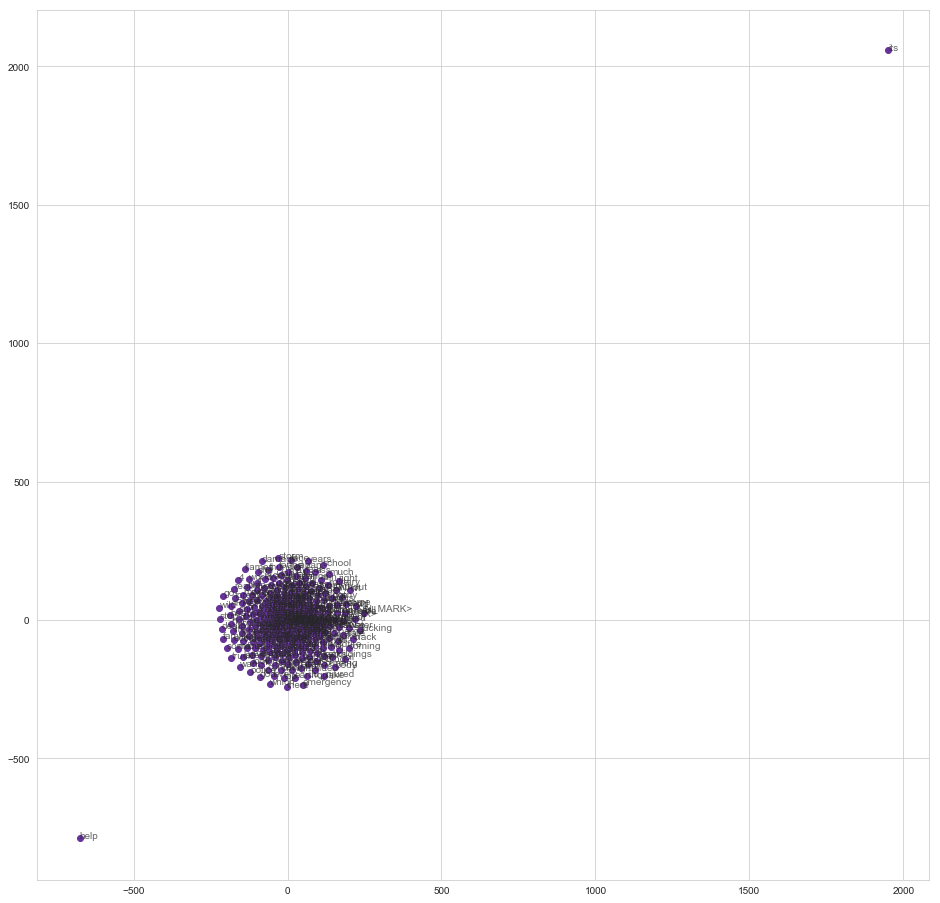

In [25]:
# Visualize

# Get embeddings from the embedding layer of our model, by name
embeddings = w2v_net.in_embed.weight.to('cpu').data.numpy()

viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color=col1)
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [29]:
# Save for later use
embeddings = w2v_net.in_embed.weight
print(embeddings.type())
print(embeddings.shape)

# Save
file_embeddings = open('embeddings.pkl', 'wb') 
pickle.dump(embeddings, file_embeddings)

torch.FloatTensor
torch.Size([3490, 300])


In [30]:
# Reload for test purpose

file_embeddings_r = open('embeddings.pkl', 'rb') 
embeddings_test = pickle.load(file_embeddings_r)

print(embeddings_test.type())
print(embeddings_test.shape)

torch.FloatTensor
torch.Size([3490, 300])


In [31]:
embeddings_test

Parameter containing:
tensor([[ 0.2400,  0.2489,  0.8631,  ..., -0.6180,  0.6164,  0.5263],
        [-0.3562,  0.3687,  0.1308,  ...,  0.1343,  0.1147, -0.3813],
        [-0.1005, -0.0252, -0.0392,  ...,  0.1566, -0.5179, -0.3652],
        ...,
        [ 0.2545,  0.2554,  0.6526,  ...,  0.0438,  0.3015, -0.5766],
        [-0.4558, -0.3475,  0.1837,  ..., -0.5723,  0.4594,  0.3439],
        [ 0.2458,  0.4525,  0.6489,  ...,  1.1045, -0.4354, -0.8410]],
       requires_grad=True)

In [ ]:
[break here]

## Appendix: Using a pre-trained Embedding

### Embedding Coverage
* When you have pre-trained embeddings, doing standard preprocessing steps  might not be a good idea because some of the valuable information can be lost. It is better to get vocabulary as close to embeddings as possible. In order to do that, `train_vocab` and `test_vocab` are created by counting the words in tweets.

In [ ]:
def build_vocab(tweets):
    vocab = {}        
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

train_tweets = df_train['text'].apply(lambda s: s.split()).values
train_vocab = build_vocab(train_tweets)
test_tweets = df_test['text'].apply(lambda s: s.split()).values
test_vocab = build_vocab(test_tweets)

Embeddings used for text cleaning are:
* GloVe-300d-840B
* FastText-Crawl-300d-2M

In [ ]:
embeddings_glove = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
embeddings_fasttext = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

Words in intersection of vocab and embeddings are stored in `covered` along with their counts. Words in vocab that don't exist in embeddings are stored in `oov` along with their counts. `n_covered` and `n_oov` are total number of counts and they are used for calculating coverage percentages.

Both GloVe and FastText embeddings have more than **50%** vocab and **80%** text coverage without cleaning. GloVe and FastText coverage are very close but GloVe has slightly higher coverage.

In [ ]:
def check_coverage(vocab, embeddings, embeddings_name, dataset_name):
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    print('{} Embeddings cover {:.2%} of {} vocab'.format(embeddings_name, vocab_coverage, dataset_name))
    print('{} Embeddings cover {:.2%} of {} text'.format(embeddings_name, text_coverage, dataset_name))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov

train_oov_glove = check_coverage(train_vocab, embeddings_glove, 'GloVe', 'Training')
test_oov_glove = check_coverage(test_vocab, embeddings_glove, 'GloVe', 'Test')
train_oov_fasttext = check_coverage(train_vocab, embeddings_fasttext, 'FastText', 'Training')
test_oov_fasttext = check_coverage(test_vocab, embeddings_fasttext, 'FastText', 'Test')

### Text Cleaning (Not Finished)
* The most common type of words in oov have punctuations at the start or end. Those words doesn't have embeddings because of those trailing punctuations. `#@!?()[]*%...'` are separated from words.
* There are special characters in tweets and some of them are attached to words. They are removed completely.
* Contractions are expanded.
* Character entity references are replaced with their actual symbols.
* Typos and slang are corrected, and informal abbreviations are written in their long forms.
* Hashtags and usernames are expanded.

In [ ]:
def clean(tweet):    
    # Punctuations at the start or end of words    
    for punctuation in "#@!?()[]*%":
        tweet = tweet.replace(punctuation, f' {punctuation} ').strip()
    tweet = tweet.replace('...', ' ... ').strip()
    tweet = tweet.replace("'", " ' ").strip()        
    
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
        
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
        
    # Hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    
    return tweet

df_train['text_cleaned'] = df_train['text'].apply(lambda x : clean(x))
df_test['text_cleaned'] = df_test['text'].apply(lambda x : clean(x))

train_tweets_cleaned = df_train['text_cleaned'].apply(lambda s: s.split()).values
train_vocab_cleaned = build_vocab(train_tweets_cleaned)
test_tweets_cleaned = df_test['text_cleaned'].apply(lambda s: s.split()).values
test_vocab_cleaned = build_vocab(test_tweets_cleaned)

train_oov_glove = check_coverage(train_vocab_cleaned, embeddings_glove, 'GloVe', 'Training')
test_oov_glove = check_coverage(test_vocab_cleaned, embeddings_glove, 'GloVe', 'Test')
train_oov_fasttext = check_coverage(train_vocab_cleaned, embeddings_fasttext, 'FastText', 'Training')
test_oov_fasttext = check_coverage(test_vocab_cleaned, embeddings_fasttext, 'FastText', 'Test')